# Next improvement attempts
### _Introduce structural information_

In [1]:
# temporary -- all code needed up to this point
import pandas as pd
import random
from random import sample
import re
import pprint

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import *

#from rdkit.Chem import MCS
from rdkit.Chem import rdFMCS
from rdkit.Chem import fmcs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import xlsxwriter

import EFGs
from EFGs import mol2frag,ifg,identify_functional_groups

#data = pd.read_csv('hob_data_set_MSMcleanup.csv')
data = pd.read_csv('bioavailability_data.csv')

In [2]:
# addition of Murcko to data
from rdkit.Chem.Scaffolds import MurckoScaffold
df = data
for index,row in df.iterrows():
    drugname = df.loc[index,'Name']
    drugSMILES = df.loc[index,'smile']
    drugmol = Chem.MolFromSmiles(drugSMILES)
    
    murcko_core = MurckoScaffold.GetScaffoldForMol(drugmol)
    result = Chem.MolToSmiles(murcko_core)
    df.loc[index,'murcko'] = result

In [3]:
''' # CLEAN SMILES '''
import re
def clean_smiles(smilesx,option=1):
    if option==2:
        expr = re.compile(r'[0-9]+\*')
        out = expr.sub('*',smilesx)
    else:
        expr = re.compile(r'\(?\[?[0-9]+\*\]?\)?')
        out = expr.sub('',smilesx)
    #out = []
    #for k in smilesList:
        #k2 = expr.sub('',k)
        #out.append(k2)
    
    return out

def clean_smiles_from_mol_list(mol_list,option=1):
    list_out = []
    for x in mol_list:
        smilesx = Chem.MolToSmiles(x)
        if option==2:
            expr = re.compile(r'[0-9]+\*')
            out = expr.sub('*',smilesx)
            list_out.append(out)
        elif option==3:
            expr = re.compile(r'\(?\[?[0-9]+\*\]?\)?')
            out = expr.sub('',smilesx)
            
            #out2 = Chem.MolFromSmiles(out)
            #out3 = Chem.MolToSmiles(out2)
            
            expr = re.compile(r'\([A-z]+\)')
            #out4 = expr.sub('',out3)
            out2 = expr.sub('',out)
            #out3 = Chem.MolFromSmiles(out2)
            #out4 = Chem.MolToSmiles(out3)
            #list_out.append(out4)
            list_out.append(out2)
        else:
            expr = re.compile(r'\(?\[?[0-9]+\*\]?\)?')
            out = expr.sub('',smilesx)
            list_out.append(out)
    return list_out

''' # BRICS FRAGMENTATION '''
from rdkit.Chem import BRICS

def gimme_BRICS(drugmol,sorting=True):
    fragMols = []
    #fragSmiles1 = []
    #fragSmiles2 = []
    
    for x in BRICS.BRICSDecompose(drugmol):
        fragMols.append(Chem.MolFromSmiles(x))
        
        #smiles = clean_smiles(x,option=1)
        #fragSmiles1.append(smiles)
        #smiles = clean_smiles(x,option=2)
        #fragSmiles2.append(smiles)
        
    if sorting:
        fragMols.sort(reverse=True,key = lambda x:x.GetNumAtoms())
    else:
        pass
    #return fragMols,fragSmiles1,fragSmiles2
    return fragMols

### visual example

Drug name:  stemazole
Drug SMILES code:	 NN=C(S)Nc1ccc(-c2nnc(S)o2)cc1
Fragment SMILES raw:	 ['[16*]c1ccc([16*])cc1', '[14*]c1nnc(S)o1', '[5*]NC(S)=NN']
Fragment SMILES v1:	 ['c1ccccc1', 'c1nnc(S)o1', 'NC(S)=NN']
Fragment SMILES v4test:	 ['c1ccccc1', 'Sc1nnco1', 'NN=C(N)S']
Fragment SMILES v2:	 ['[*]c1ccc([*])cc1', '[*]c1nnc(S)o1', '[*]NC(S)=NN']
Fragment SMILES v3:	 ['c1ccccc1', 'c1nnco1', 'NC=NN']
Murcko Frag. SMILES v3:	 ['c1ccccc1', 'c1nnco1']


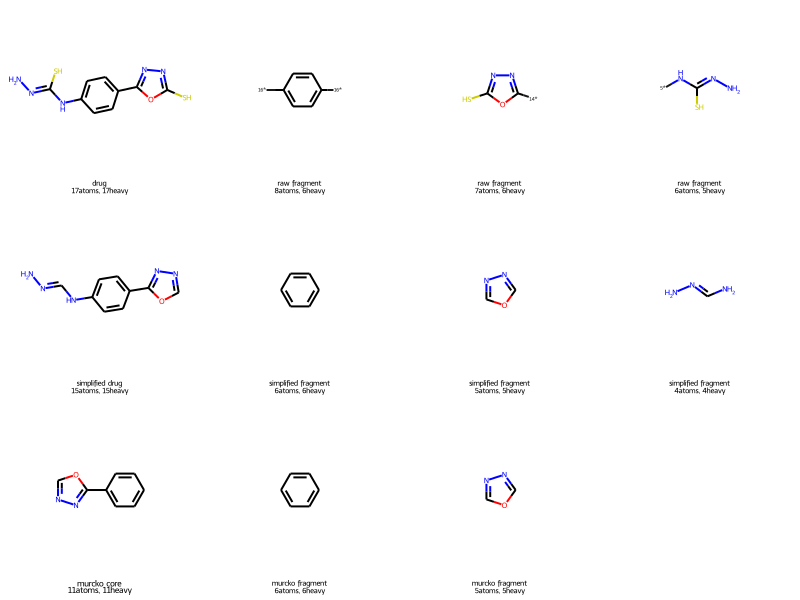

In [4]:
''' # EXAMPLE '''

testmol= Chem.MolFromSmiles(df.loc[1587,'smile'])
fragMols = gimme_BRICS(testmol)

murckomol = Chem.MolFromSmiles(df.loc[1587,'murcko'])
murckofrags = gimme_BRICS(murckomol)

fragSmiles1 = clean_smiles_from_mol_list(fragMols,option=1)
fragSmiles2 = clean_smiles_from_mol_list(fragMols,option=2)
fragSmiles3 = clean_smiles_from_mol_list(fragMols,option=3)

simplified_drug_smiles = clean_smiles_from_mol_list([testmol],option=3)[0]
simplified_drugmol = Chem.MolFromSmiles(simplified_drug_smiles)

fragSmiles4test = []
for x in fragSmiles1:
    temp = Chem.MolFromSmiles(x)
    Chem.SanitizeMol(temp)
    fragSmiles4test.append(Chem.MolToSmiles(temp))
    
murckofragSmiles3 = clean_smiles_from_mol_list(murckofrags,option=3)

frags_molFromSmiles1 = [Chem.MolFromSmiles(x) for x in fragSmiles1]
frags_molFromSmiles2 = [Chem.MolFromSmiles(x) for x in fragSmiles2]
frags_molFromSmiles3 = [Chem.MolFromSmiles(x) for x in fragSmiles3]
frags_molFromMurckoFrags = [Chem.MolFromSmiles(x) for x in murckofragSmiles3]
frags_molFromSmiles4test = [Chem.MolFromSmiles(x) for x in fragSmiles4test]
print("Drug name: ",drugname)
print("Drug SMILES code:\t",drugSMILES)
print("Fragment SMILES raw:\t",[Chem.MolToSmiles(x) for x in fragMols])
print("Fragment SMILES v1:\t",fragSmiles1)
print("Fragment SMILES v4test:\t",fragSmiles4test)
print("Fragment SMILES v2:\t",fragSmiles2)
print("Fragment SMILES v3:\t",fragSmiles3)
print("Murcko Frag. SMILES v3:\t",murckofragSmiles3)


molsOut = []
molsOut.append(drugmol)
molsOut.extend(fragMols)
molsOut.append(simplified_drugmol)
molsOut.extend(frags_molFromSmiles3)
molsOut.append(murckomol)
molsOut.extend(frags_molFromMurckoFrags)
#molsOut.extend(frags_molFromSmiles1)
#molsOut.extend(frags_molFromSmiles4test)
#molsOut.extend(frags_molFromSmiles2)

labels_i = ['drug','raw fragment','raw fragment','raw fragment',
            'simplified drug','simplified fragment','simplified fragment','simplified fragment',
            'murcko core','murcko fragment','murcko fragment']
labels = []
for i,j in enumerate(molsOut):
    part1 = labels_i[i]
    part2 = j.GetNumAtoms()
    part3 = j.GetNumHeavyAtoms()
    label = f"{part1} \n{part2}atoms, {part3}heavy"
    labels.append(label)
Draw.MolsToGridImage(molsOut,molsPerRow=4,legends=labels)

### build fragments dictionary
* We will make a Drug Dict, and a Frag Dict
* Drug Dict (PK = `drug_name`) will be used to store list of BRICS frags
* Frag Dict (PK = `frag_smiles`) will store: 
  * drug_list = list of each `drug_name`
  * size = `frag_mol.GetNumHeavyAtoms()`
  * frequency = `len(drug_list)`
* Each Frag Dict PK will be entered based on the fragment smiles BOTH v1 (simplified) and v2 (specific)

In [5]:
drug_dict = {}
frag_dict = {}
fragment_tracker = set()
frag_pairs_dict = {}

df = data
for index,row in df.iterrows():
    #if index < 50:
    drugname = df.loc[index,'Name']
    drugSMILES = df.loc[index,'smile']
    drugmol = Chem.MolFromSmiles(drugSMILES)
    Mcore_smiles = df.loc[index,'murcko']
    
    drug_dict[drugname] = {}
    drug_dict[drugname]['smiles'] = drugSMILES
    drug_dict[drugname]['mol'] = drugmol
    drug_dict[drugname]['Mcore_smiles'] = Mcore_smiles
    
    for atom in drugmol.GetAtoms():
        atom.SetIsotope(0)
    params = Chem.AdjustQueryParameters()
    params.makeBondsGeneric = True
    params.makeDummiesQueries = True
    drug_patt = Chem.AdjustQueryProperties(drugmol,params)
    
    drug_dict[drugname]['drug_patt'] = drug_patt
    
    fragMols = gimme_BRICS(drugmol)
    fragSmiles1 = clean_smiles_from_mol_list(fragMols,option=1)
    fragSmiles2 = clean_smiles_from_mol_list(fragMols,option=2)
    fragSmiles3 = clean_smiles_from_mol_list(fragMols,option=3)
    
    drug_dict[drugname]['BRICS_mols'] = fragMols
    drug_dict[drugname]['BRICS_smilesV1'] = fragSmiles1
    drug_dict[drugname]['BRICS_smilesV2'] = fragSmiles2
    drug_dict[drugname]['BRICS_smilesV3'] = fragSmiles3
    drug_dict[drugname]['BRICS_count'] = len(fragMols)
    
    
    frag_patts = []
    for fragx in fragMols:
        frag_patt = fragx
        for atom in frag_patt.GetAtoms():
            atom.SetIsotope(0)
        params = Chem.AdjustQueryParameters()
        params.makeBondsGeneric = True
        params.makeDummiesQueries = True
        frag_patt = Chem.AdjustQueryProperties(frag_patt,params)
        frag_patts.append(frag_patt)
    
    drug_dict[drugname]['frag_patts'] = frag_patts
    
    import EFGs
    from EFGs import mol2frag,ifg,identify_functional_groups
    drugFrags_EFGS = mol2frag(drugmol)[0]

    drug_dict[drugname]['frags_EFGS'] = drugFrags_EFGS
    
    # set empty lists for frag pairings (later)
    drug_dict[drugname]['BRICS_pairs_smile'] = []
    drug_dict[drugname]['BRICS_pairs_size'] = []
    drug_dict[drugname]['BRICS_pairs_frequency'] = []
    drug_dict[drugname]['BRICS_pairs_mol'] = []
    
    # also BRICS decomposition on the Murcko Scaffold, for simplified fragments
    murckomol = Chem.MolFromSmiles(df.loc[index,'murcko'])
    
    for atom in murckomol.GetAtoms():
        atom.SetIsotope(0)
    params = Chem.AdjustQueryParameters()
    params.makeBondsGeneric = True
    params.makeDummiesQueries = True
    murcko_patt = Chem.AdjustQueryProperties(murckomol,params)
    
    drug_dict[drugname]['murcko_mol'] = murckomol
    drug_dict[drugname]['murcko_patt'] = murcko_patt
    
    murckofragMols = gimme_BRICS(murckomol)
    
    murckofrag_patts = []
    for fragx in murckofragMols:
        for atom in fragx.GetAtoms():
            atom.SetIsotope(0)
        params = Chem.AdjustQueryParameters()
        params.makeBondsGeneric = True
        params.makeDummiesQueries = True
        frag_patt = Chem.AdjustQueryProperties(fragx,params)
        murckofrag_patts.append(frag_patt)
    
    drug_dict[drugname]['murckoFrag_mols'] = murckofragMols
    drug_dict[drugname]['murckoFrag_patts'] = murckofrag_patts
    
    murckofragSmiles1 = clean_smiles_from_mol_list(murckofragMols,option=1)
    murckofragSmiles3 = clean_smiles_from_mol_list(murckofragMols,option=3)
    
    drug_dict[drugname]['murckoFrag_smiles1'] = murckofragSmiles1
    drug_dict[drugname]['murckoFrag_smiles3'] = murckofragSmiles3
    drug_dict[drugname]['murckoFrag_count'] = len(murckofragMols)
    
    murckoFrags_EFGS = mol2frag(murckomol)[0]
    drug_dict[drugname]['murckoFrags_EFGS'] = murckoFrags_EFGS
    
    # categorize Sidechains using difference between All Fragments vs. Murcko (core) Fragments   
    sidechains = []
    for x in fragSmiles3:
        if x in murckofragSmiles3:
            pass
        else:
            sidechains.append(x)
    drug_dict[drugname]['sidechain_frags'] = sidechains
    
    tempset = set()
    for L in [fragSmiles1,fragSmiles2,fragSmiles3,murckofragSmiles1,murckofragSmiles3]:
        for item in L:
            tempset.add(item)
    drug_dict[drugname]['all_distinct_frags'] = tempset
    

    # Create Dictionary for Individual Fragments
    for i,j in enumerate(fragMols):
        frag_smiles_1 = fragSmiles1[i]
        frag_smiles_2 = fragSmiles2[i]
        frag_smiles_3 = fragSmiles3[i]
        frag_pattern = frag_patts[i]
        #frag_size = j.GetNumHeavyAtoms()
        
        #allfraglist = fragSmiles1[:]
        #allfraglist.extend(fragSmiles2)
        #allfraglist.extend(fragSmiles3)
        # record entries from BOTH keys... simplified (v1) + specific (v2) fragments
        for k0 in [(frag_smiles_1,'v1'),(frag_smiles_2,'v2'),(frag_smiles_3,'v3')]:
            k = k0[0]
            if k not in frag_dict.keys():
                temp_list = []
                temp_list.append(drugname)
                frag_dict[k] = {}
                #frag_dict[k]['size'] = frag_size
                frag_dict[k]['frequency'] = len(temp_list)
                frag_dict[k]['drugs'] = temp_list
                frag_dict[k]['frag_mol'] = j
                frag_dict[k]['frag_patt'] = frag_pattern
                frag_dict[k]['size'] = j.GetNumHeavyAtoms()
                templist2 = set()
                templist2.add(f"smiles_{k0[1]}")
                frag_dict[k]['source'] = templist2
            else:
                frag_dict[k]['drugs'].append(drugname) 
                frag_dict[k]['frequency'] = len(frag_dict[k]['drugs'])
                frag_dict[k]['source'].add(f"smiles_{k0[1]}")
                #frag_dict[k]['frequency'] = len(frag_dict[frag_smiles_1]['drugs'])
                
    # ADD  MURCKO CORE TO FRAG_DICT
    
    k = Mcore_smiles
    j = murckomol
    frag_size = j.GetNumHeavyAtoms()
    if k not in frag_dict.keys():
        temp_list = []
        temp_list.append(drugname)
        frag_dict[k] = {}
        frag_dict[k]['size'] = frag_size
        frag_dict[k]['frequency'] = len(temp_list)
        frag_dict[k]['drugs'] = temp_list
        frag_dict[k]['frag_mol'] = j
        frag_dict[k]['frag_patt'] = murcko_patt
        templist2 = set()
        templist2.add("murcko_core")
        frag_dict[k]['source'] = templist2
    else:
        frag_dict[k]['drugs'].append(drugname) 
        frag_dict[k]['frequency'] = len(frag_dict[k]['drugs'])
        frag_dict[k]['source'].add("murcko_core")
    
    # ALSO ADD  MURCKO FRAGMENTS TO FRAG_DICT
    for i,j in enumerate(murckofragMols):
        Mfrag_smiles_1 = murckofragSmiles1[i]
        Mfrag_smiles_3 = murckofragSmiles3[i]
        Mfrag_size = j.GetNumHeavyAtoms()
        murcko_frag_pattern = murckofrag_patts[i]
        
        #allMfraglist = murckofragSmiles1[:]
        #allMfraglist.extend(murckofragSmiles3)
        #for k in allMfraglist:
        for k0 in [(Mfrag_smiles_1,"v1"),(Mfrag_smiles_3,"v3")]:
            k = k0[0]
            if k not in frag_dict.keys():
                temp_list = []
                temp_list.append(drugname)
                frag_dict[k] = {}
                frag_dict[k]['size'] = frag_size
                frag_dict[k]['frequency'] = len(temp_list)
                frag_dict[k]['drugs'] = temp_list
                frag_dict[k]['frag_mol'] = j
                frag_dict[k]['frag_patt'] = murcko_frag_pattern
                templist2 = set()
                templist2.add(f"murckofrag_{k0[1]}")
                frag_dict[k]['source'] = templist2
            else:
                frag_dict[k]['drugs'].append(drugname) 
                frag_dict[k]['frequency'] = len(frag_dict[k]['drugs'])
                frag_dict[k]['source'].add(f"murckofrag_{k0[1]}")
    

    # Create Dictionary for Fragment pairings
    for i1,j1 in enumerate(fragSmiles3): #use fragSmiles3 because that's most simplified version
        frag_x = j1
        size_x = fragMols[i1].GetNumHeavyAtoms()

        if j1 not in frag_pairs_dict.keys():
            frag_pairs_dict[j1] = {}

        for i2,j2 in enumerate(fragSmiles3):
            if i2 == i1:
                pass
            #elif j2 in frag_pairs_dict.keys():
            #    pass
            else:
                frag_y = j2
                size_y = fragMols[i2].GetNumHeavyAtoms()

                if j2 not in frag_pairs_dict[j1].keys():
                    temp_list = []
                    temp_list.append(drugname)
                    frag_pairs_dict[j1][j2] = {}
                    frag_pairs_dict[j1][j2]['pair_size'] = (size_x + size_y)
                    frag_pairs_dict[j1][j2]['frequency'] = len(temp_list)
                    frag_pairs_dict[j1][j2]['drugs'] = temp_list
                    
                else:
                    frag_pairs_dict[j1][j2]['drugs'].append(drugname)
                    frag_pairs_dict[j1][j2]['frequency'] = len(frag_pairs_dict[j1][j2]['drugs'])
                
                drug_dict[drugname]['BRICS_pairs_smile'].append((frag_x,frag_y))
                drug_dict[drugname]['BRICS_pairs_size'].append((size_x + size_y))
                drug_dict[drugname]['BRICS_pairs_frequency'].append(len(frag_pairs_dict[j1][j2]['drugs']))
                drug_dict[drugname]['BRICS_pairs_mol'].append((fragMols[i1],fragMols[i2]))
    #else:
    #    pass

In [6]:
# Recalculate Fragment Sizes, record to Frag DIct
for frag_smiles in frag_dict.keys():
    resize = frag_dict[frag_smiles]['frag_mol'].GetNumHeavyAtoms()
    recordedSize = frag_dict[frag_smiles]['size']
    #frag_dict[frag_smiles]['size (old)'] = recordedSize
    frag_dict[frag_smiles]['size'] = resize

In [43]:
# backup!!
# save frag_dict again
import pickle
filename = 'frag_dict__final.pickle'
with open(filename, "wb") as handle:
    pickle.dump(frag_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
len(frag_dict)

5485

In [8]:
'''
# NEW VERSION - last version only searched simpler types of fragments, getting druglist3. This is druglist4 now.
'''
# Recalculate Drug/Fragment Matches, record to Frag DIct
matches = []

fragList = enumerate([x for x in frag_dict.keys()])
drugList = [x for x in drug_dict.keys()]
              
for i,j in fragList:
    
    frag_dict[j]['druglist4'] = []
    
    #if frag_dict[j]['source'].intersection({'murckofrag_v3','smiles_v3','murcko_core'}) != set():
    fragPattern = frag_dict[j]['frag_patt']

    for index,key in enumerate(drugList):
        drugmol = drug_dict[key]['mol']

        drugname = key
        drugmol = drug_dict[drugname]['mol']
        drug_patt = drug_dict[drugname]['drug_patt']
        drug_murcko_patt = drug_dict[drugname]['murcko_patt']

        if drug_patt.HasSubstructMatch(fragPattern):
            frag_dict[j]['druglist4'].append(key)
            frag_dict[j]['frequency4'] = len(frag_dict[j]['druglist4'])

        # New snippet - if drug pattern doesnt match fragment, check drug murcko as well
        elif drug_murcko_patt.HasSubstructMatch(fragPattern):
            if key not in set(frag_dict[j]['druglist4']):
                frag_dict[j]['druglist4'].append(key)
                frag_dict[j]['frequency4'] = len(frag_dict[j]['druglist4'])

In [9]:
'''
# NEW - using frag_dict 'druglist4', let's update drug_dict 'fragments4'
'''
frags = [(n,idx) for (n,idx) in enumerate(frag_dict.keys())]

for idx,frag in frags:
    
    frag_size = frag_dict[frag]['size']
    frag_freq = len(frag_dict[frag]['druglist4'])
    
    frag_info = (frag, frag_size, frag_freq)
    
    drug_info = []
    for drug in frag_dict[frag]['druglist4']:
        
        if 'fragments4' not in drug_dict[drug].keys():
            
            drug_dict[drug]['fragments4'] = []
            drug_dict[drug]['fragments4'].append( frag_info )
            
            drug_dict[drug]['fragments4_short'] = []
            drug_dict[drug]['fragments4_short'].append( frag )
            
        else:
            drug_dict[drug]['fragments4'].append( frag_info )
            drug_dict[drug]['fragments4_short'].append( frag )
        
        
        drug_row_index     =  df[df['Name'] == drug].index[0]
        drug_BA_value      =  df['value (oral BA %)'][drug_row_index]
        
        drug_info.append( (drug, drug_BA_value) )
        
        drug_dict[drug]['bioavailability'] = drug_BA_value
    
    # save new data in frag_dict
    if 'parent_drug_info' not in frag_dict[frag].keys(): 
        frag_dict[frag]['parent_drug_info'] = drug_info
    else:
        frag_dict[frag]['parent_drug_info'].extend(drug_info)

In [10]:
# backup!!
# save frag_dict again
import pickle
filename = 'frag_dict__final.pickle'
with open(filename, "wb") as handle:
    pickle.dump(frag_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
filename = 'drug_dict__final.pickle'
with open(filename, "wb") as handle:
    pickle.dump(drug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

* (below) this combines `'drugs'` & `'druglist3'` column of `frag_dict` into `'druglist_final'` 
* <font color='red'> in latest version, we `'druglist3'` should already be equal to `'druglist_final'` </font>

In [11]:
count = 0
for idx,frag in frags:
    druglist_orig = frag_dict[frag]['drugs']
    druglist_v4 = frag_dict[frag]['druglist4']
    drugs_consolidated = set()
    [drugs_consolidated.add(x) for x in druglist_orig]
    [drugs_consolidated.add(x) for x in druglist_v4]
    frag_dict[frag]['druglist4_final'] = drugs_consolidated
    frag_dict[frag]['frequency4_final'] = len(drugs_consolidated)
    
    # delete incorrect parent_drug_info entries
    if 'parent_drug_info' in frag_dict[frag].keys():
        del frag_dict[frag]['parent_drug_info']

* (below) this takes newly-combined `'druglist_final'` column of `frag_dict` , <br> and to each drug listed there, adds the current fragment to `'fragments_final'` of `'drug_dict'`
* <font color='red'> in latest version, we `'fragments3'`/`'fragments3_short'` should already be equal to `'fragments_final'` </font>

In [12]:
frags = [(n,idx) for (n,idx) in enumerate(frag_dict.keys())]

for idx,frag in frags:
    drugs_list = frag_dict[frag]['druglist4_final'] 
    frag_freq = frag_dict[frag]['frequency4_final'] 
    frag_size = frag_dict[frag]['size']
    
    frag_info = (frag, frag_size, frag_freq)
    
    drug_info = []
    for drug in drugs_list:
        drugdictkey1 = 'fragmentsInfo4_final'
        drugdictkey2 = 'fragments4_final'
        
        if drugdictkey2 not in drug_dict[drug].keys():
            
            drug_dict[drug][drugdictkey1] = []
            drug_dict[drug][drugdictkey1].append( frag_info )
            
            drug_dict[drug][drugdictkey2] = []
            drug_dict[drug][drugdictkey2].append( frag )
            
            drug_dict[drug]['fragment4_count'] = 1
            
        else:
            drug_dict[drug][drugdictkey1].append( frag_info )
            drug_dict[drug][drugdictkey2].append( frag )
            drug_dict[drug]['fragment4_count'] = len(drug_dict[drug][drugdictkey2])
        
        drug_row_index     =  df[df['Name'] == drug].index[0]
        drug_BA_value      =  df['value (oral BA %)'][drug_row_index] #drug_dict[drug]['bioavailability']
        drug_info.append( (drug, drug_BA_value) )
        
        # -- record BA value in drug_dict for future reference
        drug_dict[drug]['bioavailability'] = drug_BA_value
    
    # save new data in frag_dict
    if 'parent_drug_info' not in frag_dict[frag].keys(): 
        frag_dict[frag]['parent_drug_info'] = drug_info
    else:
        frag_dict[frag]['parent_drug_info'].extend(drug_info)

* this step eliminates duplicate fragment entries by converting `'fragments_final'` to a `set`
* thus, also updates `'count_frags_final_set'` 

In [51]:
frag_dict['O=S(=O)(Nc1ncccn1)c1ccccc1'].keys()

dict_keys(['size', 'frequency', 'drugs', 'frag_mol', 'frag_patt', 'source', 'druglist3', 'frequency3', 'parent_drug_info'])

In [68]:
drug_dict['sulfadiazine'].keys()

dict_keys(['smiles', 'mol', 'Mcore_smiles', 'drug_patt', 'BRICS_mols', 'BRICS_smilesV1', 'BRICS_smilesV2', 'BRICS_smilesV3', 'BRICS_count', 'frag_patts', 'frags_EFGS', 'BRICS_pairs_smile', 'BRICS_pairs_size', 'BRICS_pairs_frequency', 'BRICS_pairs_mol', 'murcko_mol', 'murcko_patt', 'murckoFrag_mols', 'murckoFrag_patts', 'murckoFrag_smiles1', 'murckoFrag_smiles3', 'murckoFrag_count', 'murckoFrags_EFGS', 'sidechain_frags', 'all_distinct_frags', 'fragments3', 'fragments3_short', 'bioavailability', 'fragments4', 'fragments4_short', 'fragmentsInfo3_final', 'fragments3_final', 'fragment_count', 'fragmentsInfo4_final', 'fragments4_final', 'fragment4_count'])

# NEXT

### update column titles in drug_dict & frag_dict, save, then proceed below w/ updated filename

In [13]:
drugs = [(n,idx) for (n,idx) in enumerate(drug_dict.keys())]
for idx,drug in drugs:
    #drug_fragset = drug_dict[drug]['fragments_final']
    drug_fragset = drug_dict[drug]['fragmentsInfo4_final']
    #drug_fragset = drug_dict[drug]['fragmentsInfo4_final']
    
    fragments_subset = []
    fragments_subset2 = []
    
    for (frag,frag_size,frag_freq) in drug_fragset:
        if frag_freq > 2 and frag_size > 2 and frag_size < 25:
            #fragments_subset.append((frag,frag_size,frag_freq))
            fragments_subset.append(frag)
            if frag_freq < 1000 and re.findall('[\[,\],\*,\@,\#]',x) == []:
                fragments_subset2.append(frag)
            
    drug_dict[drug]['fragments4_subset'] = fragments_subset
    drug_dict[drug]['fragments4_subset2'] = fragments_subset2
    drug_dict[drug]['count_frags4_subset'] = len(fragments_subset)
    drug_dict[drug]['count_frags4_subset2'] = len(fragments_subset2)

In [14]:
# backup!!
# save frag_dict again
import pickle
filename = 'frag_dict__final.pickle'
with open(filename, "wb") as handle:
    pickle.dump(frag_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
filename = 'drug_dict__final.pickle'
with open(filename, "wb") as handle:
    pickle.dump(drug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
drug_dict_df = pd.DataFrame.from_dict(drug_dict)
drug_dict_df = drug_dict_df.transpose()
drug_dict_df.reset_index(inplace=True)
drug_dict_df = drug_dict_df.rename(columns={'index':'drug_name'})

In [16]:
df_out = drug_dict_df[['drug_name','smiles','bioavailability',
                       #'fragmentsInfo3_final','fragment_count',
                       #'fragmentsInfo4_final','fragment4_count',
                       #'fragments3_final','fragment_count',
                       'fragments4_final','fragment4_count',
                       #'fragments3_subset','count_frags3_subset',
                       'fragments4_subset','count_frags4_subset',
                       #'fragments3_subset2',
                       'fragments4_subset2',
                       'frags_EFGS','BRICS_smilesV3']]#,'BRICS_count']]
#df_out.head()

In [17]:
df_out = df_out.rename(columns={'smiles':'drug_smiles', 
                                      'bioavailability':'ba_pct',
                                      #'fragments3_final':'frags3_all',
                                      'fragments4_final':'frags_all',
                                      #'fragment_count':'num_frags3_all',
                                      'fragment4_count':'num_frags_all',
                                'fragments4_subset':'frags_subset',
                                'count_frags4_subset':'num_frags_subset',
                                'fragments4_subset2':'frags_subset2',
                                      'frags_EFGS':'frags_efgs',
                                      'BRICS_smilesV3':'frags_brics'})
df_out.head()

,drug_name,drug_smiles,ba_pct,frags_all,num_frags_all,frags_subset,num_frags_subset,frags_subset2,frags_efgs,frags_brics
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90.0,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...",126,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...",100,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...","[N, NS(=O)=O, c1cncnc1, c1ccccc1]","[S(=O)(=O)c1ccccc1, c1ncccn1, N]"
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50.0,"[N, [*]N[*], *N*, n1cnc2c(N)nc(Cl)nc21, [*]n1c...",237,"[n1cnc2cncnc21, C1OCCC1O, c1ncc2ncn(C3CCCO3)c2...",194,"[n1cnc2cncnc21, C1OCCC1O, c1ncc2ncn(C3CCCO3)c2...","[N, Cl, O, O, O, F, c1ncc2nc[nH]c2n1]","[n1cnc2cncnc21, C1OCCC1O, CO]"
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99.0,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...",164,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...",125,"[S(=O)(=O)c1ccc(N)cc1, [*]S(=O)(=O)c1ccc(N)cc1...","[NS(=O)=O, N, c1ccccc1, c1cnoc1]","[S(=O)(=O)c1ccccc1, c1ccon1, N]"
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90.0,"[N, [*]N[*], *N*, CC1=NCCN1, [*]CC1=NCCN1, c1c...",102,"[CC1=NCCN1, [*]CC1=NCCN1, c1ccccc1, [*]c1ccccc...",80,"[CC1=NCCN1, [*]CC1=NCCN1, c1ccccc1, [*]c1ccccc...","[N=CN, c1ccccc1]","[CC1=NCCN1, c1ccccc1]"
4,cotinine,CN1C(=O)CCC1c1cccnc1,97.0,"[N, [*]N[*], *N*, CO, [*]CO, C1CCC(=O)N1C, [*]...",175,"[c1cccnc1, [*]c1cccnc1, *c1cccnc1, *C1CCC(=O)N...",142,"[c1cccnc1, [*]c1cccnc1, *c1cccnc1, *C1CCC(=O)N...","[NC=O, c1ccncc1]","[C1CCC(=O)N1C, c1cccnc1]"


In [18]:
df_out.to_pickle('bioavailabilityData_w_Frags__final.pkl')